# LSTM

## CalamanCy

### New New Implementation
https://jaketae.github.io/study/word2vec/

In [1]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''


In [2]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())


In [3]:
tokens = tokenize(text)
tokens

['machine',
 'learning',
 'is',
 'the',
 'study',
 'of',
 'computer',
 'algorithms',
 'that',
 'improve',
 'automatically',
 'through',
 'experience',
 'it',
 'is',
 'seen',
 'as',
 'a',
 'subset',
 'of',
 'artificial',
 'intelligence',
 'machine',
 'learning',
 'algorithms',
 'build',
 'a',
 'mathematical',
 'model',
 'based',
 'on',
 'sample',
 'data',
 'known',
 'as',
 'training',
 'data',
 'in',
 'order',
 'to',
 'make',
 'predictions',
 'or',
 'decisions',
 'without',
 'being',
 'explicitly',
 'programmed',
 'to',
 'do',
 'so',
 'machine',
 'learning',
 'algorithms',
 'are',
 'used',
 'in',
 'a',
 'wide',
 'variety',
 'of',
 'applications',
 'such',
 'as',
 'email',
 'filtering',
 'and',
 'computer',
 'vision',
 'where',
 'it',
 'is',
 'difficult',
 'or',
 'infeasible',
 'to',
 'develop',
 'conventional',
 'algorithms',
 'to',
 'perform',
 'the',
 'needed',
 'tasks']

In [4]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(sorted(set(tokens))):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [5]:
word_to_id, id_to_word = mapping(tokens)
word_to_id

{'a': 0,
 'algorithms': 1,
 'and': 2,
 'applications': 3,
 'are': 4,
 'artificial': 5,
 'as': 6,
 'automatically': 7,
 'based': 8,
 'being': 9,
 'build': 10,
 'computer': 11,
 'conventional': 12,
 'data': 13,
 'decisions': 14,
 'develop': 15,
 'difficult': 16,
 'do': 17,
 'email': 18,
 'experience': 19,
 'explicitly': 20,
 'filtering': 21,
 'improve': 22,
 'in': 23,
 'infeasible': 24,
 'intelligence': 25,
 'is': 26,
 'it': 27,
 'known': 28,
 'learning': 29,
 'machine': 30,
 'make': 31,
 'mathematical': 32,
 'model': 33,
 'needed': 34,
 'of': 35,
 'on': 36,
 'or': 37,
 'order': 38,
 'perform': 39,
 'predictions': 40,
 'programmed': 41,
 'sample': 42,
 'seen': 43,
 'so': 44,
 'study': 45,
 'subset': 46,
 'such': 47,
 'tasks': 48,
 'that': 49,
 'the': 50,
 'through': 51,
 'to': 52,
 'training': 53,
 'used': 54,
 'variety': 55,
 'vision': 56,
 'where': 57,
 'wide': 58,
 'without': 59}

In [6]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [7]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [8]:
import numpy as np

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [9]:
X, y = generate_training_data(tokens, word_to_id, 2)

In [10]:
from scipy import sparse

print(sparse.csr_matrix(X))

  (0, 30)	1
  (1, 30)	1
  (2, 29)	1
  (3, 29)	1
  (4, 29)	1
  (5, 26)	1
  (6, 26)	1
  (7, 26)	1
  (8, 26)	1
  (9, 50)	1
  (10, 50)	1
  (11, 50)	1
  (12, 50)	1
  (13, 45)	1
  (14, 45)	1
  (15, 45)	1
  (16, 45)	1
  (17, 35)	1
  (18, 35)	1
  (19, 35)	1
  (20, 35)	1
  (21, 11)	1
  (22, 11)	1
  (23, 11)	1
  (24, 11)	1
  :	:
  (305, 12)	1
  (306, 12)	1
  (307, 12)	1
  (308, 12)	1
  (309, 1)	1
  (310, 1)	1
  (311, 1)	1
  (312, 1)	1
  (313, 52)	1
  (314, 52)	1
  (315, 52)	1
  (316, 52)	1
  (317, 39)	1
  (318, 39)	1
  (319, 39)	1
  (320, 39)	1
  (321, 50)	1
  (322, 50)	1
  (323, 50)	1
  (324, 50)	1
  (325, 34)	1
  (326, 34)	1
  (327, 34)	1
  (328, 48)	1
  (329, 48)	1


In [11]:
print(sparse.csr_matrix(y))

  (0, 29)	1
  (1, 26)	1
  (2, 30)	1
  (3, 26)	1
  (4, 50)	1
  (5, 30)	1
  (6, 29)	1
  (7, 50)	1
  (8, 45)	1
  (9, 29)	1
  (10, 26)	1
  (11, 45)	1
  (12, 35)	1
  (13, 26)	1
  (14, 50)	1
  (15, 35)	1
  (16, 11)	1
  (17, 50)	1
  (18, 45)	1
  (19, 11)	1
  (20, 1)	1
  (21, 45)	1
  (22, 35)	1
  (23, 1)	1
  (24, 49)	1
  :	:
  (305, 52)	1
  (306, 15)	1
  (307, 1)	1
  (308, 52)	1
  (309, 15)	1
  (310, 12)	1
  (311, 52)	1
  (312, 39)	1
  (313, 12)	1
  (314, 1)	1
  (315, 39)	1
  (316, 50)	1
  (317, 1)	1
  (318, 52)	1
  (319, 50)	1
  (320, 34)	1
  (321, 52)	1
  (322, 39)	1
  (323, 34)	1
  (324, 48)	1
  (325, 39)	1
  (326, 50)	1
  (327, 48)	1
  (328, 50)	1
  (329, 34)	1


In [12]:
X.shape

(330, 60)

In [13]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
        # "w1": np.zeros((vocab_size, n_embedding)),
        # "w2": np.zeros((n_embedding, vocab_size))
    }
    return model


In [14]:
model = init_network(len(word_to_id), 10)
model


{'w1': array([[-0.0261038 ,  0.55456146, -0.67144111,  0.06244403, -0.59340864,
          1.22453657, -1.99139315, -1.55311568, -1.37022761,  0.36040531],
        [ 1.61808721,  0.18552983, -1.01931174,  0.54229863, -1.46624626,
         -0.21308819,  0.89429618,  0.22806185,  0.70074409, -0.84087744],
        [-0.92590897, -0.73714553, -0.9809259 ,  0.26215208,  0.83440515,
         -2.43473289, -1.33010377, -0.78072689, -0.39707907,  0.20214174],
        [-1.68899143, -0.75948252, -0.80212219, -1.40614698, -0.6975631 ,
          0.38524435, -0.43170962, -0.31046822,  1.76165189, -0.79788684],
        [ 0.83814948,  1.19437174,  0.72394757, -0.50531021, -0.25004871,
          0.08537454,  2.22767654,  0.76530472,  0.04698899, -0.21697362],
        [ 0.55232503, -0.76572535,  0.34543008,  0.32393555, -0.89439329,
          2.49319312, -0.97485878,  1.28782502,  0.63208712, -2.00796456],
        [-1.39596622,  2.02596481,  0.36511777,  0.0729329 ,  0.17967553,
         -1.68469874, -1.0

In [22]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache


In [16]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [17]:
X.shape

(330, 60)

In [18]:
(X @ model["w1"]).shape

(330, 10)

In [19]:
(X @ model["w1"] @ model["w2"]).shape

(330, 60)

In [20]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)


In [23]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

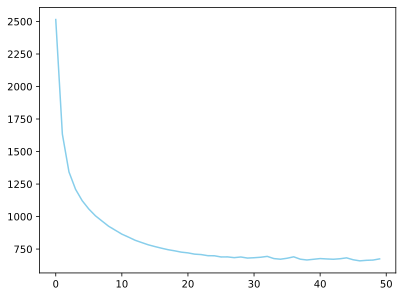

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()


In [28]:
history

[2515.3323692445288,
 1634.2670485080705,
 1343.2795286110895,
 1209.3310473908941,
 1122.1310724778978,
 1058.0264080646732,
 1005.9372416317478,
 965.4363655444673,
 925.5342923866373,
 895.1279409383872,
 864.7765625925804,
 841.9964678257959,
 817.9212194761269,
 800.1918073374154,
 782.7844487245868,
 769.2925784779773,
 756.6932268943185,
 745.0625499225908,
 736.4293055169635,
 726.3095636949149,
 720.7837225314494,
 711.0483922466407,
 707.7034494162347,
 699.1689371252278,
 698.4312062750461,
 689.3392170857228,
 689.7453369989614,
 684.0486361730875,
 689.1428350352992,
 680.8713074272279,
 683.3896230674742,
 687.1352934133191,
 693.7964560127627,
 676.9575258060904,
 672.0354249790869,
 679.4069590770539,
 690.4440568845221,
 672.2200907462184,
 666.1063742597993,
 671.5048321471544,
 676.9521903330561,
 674.0332190321221,
 671.6778613127467,
 675.5547488684174,
 682.4302552641558,
 667.8187271292346,
 659.4108969296776,
 663.5479550783657,
 665.388696492778,
 674.673305679

In [22]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
the
intelligence
so
are
build
is
make
to
improve
algorithms
automatically
it
learning
needed
experience
that
study
subset
programmed
a
computer
through
develop
conventional
or
artificial
training
wide
email
decisions
perform
infeasible
as
difficult
such
applications
seen
without
order
and
sample
predictions
data
used
of
filtering
tasks
do
variety
being
mathematical
in
where
explicitly
based
vision
known
model
on


In [24]:
model['w1']

array([[-8.58673970e-01,  5.33832103e-01,  3.21180659e-01,
         9.23299171e-01,  6.71020858e-01,  3.96155159e-01,
         4.30351871e-01,  3.01920016e-01, -6.37851366e-01,
        -5.11848606e-01],
       [ 2.46245109e-01, -1.72717793e-01, -7.43365496e-02,
         2.02841717e-01,  2.31632651e+00, -1.30524626e-01,
        -4.40548831e-01,  8.72856444e-01, -1.17370788e-01,
        -1.34890438e+00],
       [ 3.15838228e-01,  1.91022776e+00,  1.04961414e-01,
        -1.61358222e+00, -5.49170665e-01, -9.31378862e-01,
        -1.21020758e-01, -1.13594691e+00,  5.96529232e-01,
        -6.63464712e-01],
       [-6.40460448e-01,  1.10083520e+00, -7.39617025e-02,
         2.43985241e-01, -4.60601193e-02, -2.09734410e+00,
         7.92357222e-01,  1.40348842e-01, -1.23132021e+00,
        -7.33402605e-01],
       [-6.92687808e-02,  9.33744175e-01, -8.36795034e-01,
         2.44869387e-01,  2.64125374e+00,  1.23821703e+00,
        -2.42630969e-03,  8.05374221e-02,  5.45864594e-01,
        -2.

In [25]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [26]:
get_embedding(model, "machine")


array([ 1.73593864,  0.6575379 , -1.79653571, -0.05580517,  0.43392639,
        0.60106108,  0.00677222,  0.14199149,  1.15587206,  0.51696468])

In [32]:
model['w1'].shape

(60, 10)

In [33]:
word_to_id['machine']

30

In [34]:
model['w1'][30]

array([ 1.73593864,  0.6575379 , -1.79653571, -0.05580517,  0.43392639,
        0.60106108,  0.00677222,  0.14199149,  1.15587206,  0.51696468])

### [New implementation](https://nathanrooy.github.io/posts/2018-03-22/word2vec-from-scratch-with-python-and-numpy/)

In [ ]:
#------------------------------------------------------------------------------+
#
#   Nathan A. Rooy
#   Simple word2vec from scratch with Python
#   2018-FEB
#
#------------------------------------------------------------------------------+

#--- IMPORT DEPENDENCIES ------------------------------------------------------+

import numpy as np
import re
from collections import defaultdict

#--- CONSTANTS ----------------------------------------------------------------+


class word2vec():
    def __init__ (self):
        self.n = settings['n']
        self.eta = settings['learning_rate']
        self.epochs = settings['epochs']
        self.window = settings['window_size']
        pass
    
    
    # GENERATE TRAINING DATA
    def generate_training_data(self, settings, corpus):

        # GENERATE WORD COUNTS
        word_counts = defaultdict(int)
        for row in corpus:
            for word in row:
                word_counts[word] += 1

        self.v_count = len(word_counts.keys())

        # GENERATE LOOKUP DICTIONARIES
        self.words_list = sorted(list(word_counts.keys()),reverse=False)
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list))

        training_data = []
        # CYCLE THROUGH EACH SENTENCE IN CORPUS
        for sentence in corpus:
            sent_len = len(sentence)

            # CYCLE THROUGH EACH WORD IN SENTENCE
            for i, word in enumerate(sentence):
                
                #w_target  = sentence[i]
                w_target = self.word2onehot(sentence[i])

                # CYCLE THROUGH CONTEXT WINDOW
                w_context = []
                for j in range(i-self.window, i+self.window+1):
                    if j!=i and j<=sent_len-1 and j>=0:
                        w_context.append(self.word2onehot(sentence[j]))
                training_data.append([w_target, w_context])
        print(training_data)
        return np.array(training_data)


    # SOFTMAX ACTIVATION FUNCTION
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)


    # CONVERT WORD TO ONE HOT ENCODING
    def word2onehot(self, word):
        word_vec = [0 for i in range(0, self.v_count)]
        word_index = self.word_index[word]
        word_vec[word_index] = 1
        return word_vec


    # FORWARD PASS
    def forward_pass(self, x):
        h = np.dot(self.w1.T, x)
        u = np.dot(self.w2.T, h)
        y_c = self.softmax(u)
        return y_c, h, u
                

    # BACKPROPAGATION
    def backprop(self, e, h, x):
        dl_dw2 = np.outer(h, e)  
        dl_dw1 = np.outer(x, np.dot(self.w2, e.T))

        # UPDATE WEIGHTS
        self.w1 = self.w1 - (self.eta * dl_dw1)
        self.w2 = self.w2 - (self.eta * dl_dw2)
        pass


    # TRAIN W2V model
    def train(self, training_data):
        # INITIALIZE WEIGHT MATRICES
        self.w1 = np.random.uniform(-0.8, 0.8, (self.v_count, self.n))     # embedding matrix
        self.w2 = np.random.uniform(-0.8, 0.8, (self.n, self.v_count))     # context matrix
        
        # CYCLE THROUGH EACH EPOCH
        for i in range(0, self.epochs):

            self.loss = 0

            # CYCLE THROUGH EACH TRAINING SAMPLE
            for w_t, w_c in training_data:

                # FORWARD PASS
                y_pred, h, u = self.forward_pass(w_t)
                
                # CALCULATE ERROR
                EI = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)

                # BACKPROPAGATION
                self.backprop(EI, h, w_t)

                # CALCULATE LOSS
                self.loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))
                #self.loss += -2*np.log(len(w_c)) -np.sum([u[word.index(1)] for word in w_c]) + (len(w_c) * np.log(np.sum(np.exp(u))))
                
            print('EPOCH:',i, 'LOSS:', self.loss)
        pass


    # input a word, returns a vector (if available)
    def word_vec(self, word):
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
        return v_w


    # input a vector, returns nearest word(s)
    def vec_sim(self, vec, top_n):

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_num = np.dot(vec, v_w2)
            theta_den = np.linalg.norm(vec) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda word, sim:sim, reverse=True)

        for word, sim in words_sorted[:top_n]:
            print(word, sim)
            
        pass

    # input word, returns top [n] most similar words
    def word_sim(self, word, top_n):
        
        w1_index = self.word_index[word]
        v_w1 = self.w1[w1_index]

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_num = np.dot(v_w1, v_w2)
            theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda word, sim:sim, reverse=True)

        for word, sim in words_sorted[:top_n]:
            print(word, sim)
            
        pass


In [ ]:
settings = {}
settings['n'] = 5                   # dimension of word embeddings
settings['window_size'] = 2         # context window +/- center word
settings['min_count'] = 0           # minimum word count
settings['epochs'] = 5000           # number of training epochs
settings['neg_samp'] = 10           # number of negative words to use during training
settings['learning_rate'] = 0.01    # learning rate
np.random.seed(0)                   # set the seed for reproducibility

In [ ]:
corpus = [
  ['the','quick','brown','fox','jumped','over','the','lazy','dog'],
  'i didn\'t know scrub daddy sells the sponges but frowning'.lower().split()
]

In [ ]:
# INITIALIZE W2V MODEL
w2v = word2vec()

In [ ]:
# generate training data
# training_data = w2v.generate_training_data(settings, corpus)

In [ ]:
# train word2vec model
# w2v.train(training_data)

In [ ]:
# w2v.words_list

### Other implementation

Calamancy vectors are trained from a skip-gram model.

In [ ]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

/tmp/ipykernel_17567/3484305165.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Read Data

In [ ]:
with open('./misc/stopwords.txt') as f:
  stopwords = f.read().replace('\n', ' ').split()

In [ ]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [ ]:
with open('./misc/training_text.txt') as f:
  text = f.read().replace('\n', '')
  text = text.translate(
    str.maketrans('', '', string.punctuation)
  )
  text = ''.join([t for t in text if t not in '0123456789'])
  text = text.lower().split()

text = [w for w in text if w not in stopwords][:2000]

In [ ]:
text

['today',
 'learning',
 'fundamentals',
 'data',
 'science',
 'statistics',
 'data',
 'science',
 'statistics',
 'hot',
 'growing',
 'fields',
 'alternative',
 'names',
 'machine',
 'learning',
 'artificial',
 'intelligence',
 'big',
 'data',
 'etc',
 'im',
 'really',
 'excited',
 'talk',
 'data',
 'science',
 'statistics',
 'data',
 'science',
 'statistics',
 'long',
 'passions',
 'mine',
 'didnt',
 'used',
 'good',
 'data',
 'science',
 'statistics',
 'studying',
 'data',
 'science',
 'statistics',
 'long',
 'time',
 'got',
 'better',
 'better',
 'became',
 'data',
 'science',
 'statistics',
 'expert',
 'im',
 'really',
 'excited',
 'talk',
 'data',
 'science',
 'statistics',
 'thanks',
 'listening',
 'talk',
 'data',
 'science',
 'statistics']

#### Prepare Training Data

In [ ]:
# Introduce negative samples so model knows what are
# context words as well as what are not context words

WINDOW_SIZE = 3
NUM_NEGATIVE_SAMPLES = 3

data = []

# Iterate over all words
for index, center_word in enumerate(
  text[WINDOW_SIZE - 1 : -WINDOW_SIZE]
):
  # Iterate over context words around center word
  context_words = [
    context_word 
    for context_word 
    in text[index : index + 2 * WINDOW_SIZE-1] 
    if context_word != center_word
  ]

  # Get words not in context as negative samples
  for context_word in context_words:
    data.append([center_word, context_word, 1])
    negative_samples = np.random.choice([
      w 
      for w
      in text[WINDOW_SIZE - 1 : -WINDOW_SIZE]
      if w != center_word
      and w not in context_words
    ], NUM_NEGATIVE_SAMPLES)

    for negative_sample in negative_samples:
      data.append([center_word, negative_sample, 0])

In [ ]:
pd.DataFrame(data)

,0,1,2
0,fundamentals,today,1
1,fundamentals,statistics,0
2,fundamentals,growing,0
3,fundamentals,growing,0
4,fundamentals,learning,1
...,...,...,...
979,talk,im,0
980,talk,science,1
981,talk,studying,0
982,talk,got,0


## LSTM Architecture

![Alt text](assets/image.png)

### Forget Gate

![Alt text](assets/image-4.png)

$ f_t = sigmoid(W_f * [h_{t-1},x_t] + b_f) $

Forget gate decides what information will be retained in the cell state.

Multiply the weight of the forget gate $ W_t $ with previous state $ h_{t-1} $ and current input $ x_t $. Add the bias of the forget gate $ b_f $.

The sigmoid function turns this into a value between 0 and 1 indicating how much percent of cell state to keep.

```python

```

### Input Gate

![Alt text](assets/image-5.png)

$ i_t = sigmoid(W_i * [h_{t-1},x_t] + b_i) $

The input gate decides which values to update in the cell state and by how much.

$ \~{C_t} = tanh(W_C * [h_{t-1},x_t] + b_C) $

$ \~{C_t} $ determines the new values to be added to the cell state.

### Cell State

![Alt text](assets/image-1.png)

$ C_t = f_t * C_{t-1} + i_t * \tilde{C} $

Cell state is the long term memory. It forgets some information from the previous step in the sequence, then adds new information calculated from the input gate, forming the updated cell state.

### Output Gate

![Alt text](./assets/image-6.png)

$ o_t = sigmoid(W_o [h_{t-1},x_t] + b_o) $

The output gate determines which values in the cell state will be forwarded.

$ h_t = o_t * tanh(C_t) $

The hidden state calculates the output by multiplying the output gate and a $ tanh $-filtered cell state. It doubly functions as the short term memory for the next input in the sequence.

The `hidden_size` parameter determines the size, or dimensions, of the hidden state.

### Source

https://github.com/pytorch/pytorch/blob/9347a79f1c35c76535310111d1c50bada4e975a8/aten/src/ATen/native/RNN.cpp#L716

Get result of $ W_h(h_{t-1}) + W_i(x_t) + b_h + b_i $
```cpp
const auto gates = params.linear_hh(hx).add_(
    pre_compute_input ? input : params.linear_ih(input));
```

Apply activation to each gate
```cpp
auto chunked_gates = gates.unsafe_chunk(4, 1);
auto ingate = chunked_gates[0].sigmoid_();
auto forgetgate = chunked_gates[1].sigmoid_();
auto cellgate = chunked_gates[2].tanh_();
auto outgate = chunked_gates[3].sigmoid_();
```

Update cell state (long term) and hidden state (short term)
```cpp
auto cy = (forgetgate * cx).add_(ingate * cellgate);
auto hy = outgate * cy.tanh();
return std::make_tuple(std::move(hy), std::move(cy));
```